### Real or Not? NLP with Disaster Tweets
Objective : Predict which Tweets are about real disasters and which ones are not.¶

In [1]:
#python basics
from matplotlib import pyplot as plt
import math, os, re, time, random, string
import numpy as np, pandas as pd, seaborn as sns

#this is just cool
from tqdm import tqdm

#visualization
import matplotlib.pyplot as plt
plt.style.use('ggplot')   #for optimum aesthetics 
import seaborn as sns

#natural language processing
from collections import defaultdict
import wordcloud

#ignore warnings because they are annoying
import warnings
warnings.filterwarnings('ignore')

#for neural nets
import tensorflow as tf

In [2]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
seed_everything(34)

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
#save ID
test_id = test['id']

#drop from train and test
columns = {'id', 'location'}
train = train.drop(columns = columns)
test = test.drop(columns = columns)

#fill missing with unknown
train['keyword'] = train['keyword'].fillna('')
test['keyword'] = test['keyword'].fillna('')

#add keyword to tweets
train['text'] = train['text'] + ' ' + train['keyword']
test['text'] = test['text'] + ' ' + test['keyword']

#drop fkeyword rom train and test
columns = {'keyword'}
train = train.drop(columns = columns)
test = test.drop(columns = columns)

#combine so we work smarter, not harder
total = train.append(test)

In [5]:
print('There are', len(train), 'rows in the train set')
print('There are', len(test), 'rows in the test set')

There are 7613 rows in the train set
There are 3263 rows in the test set


#### Distribution of Target classes

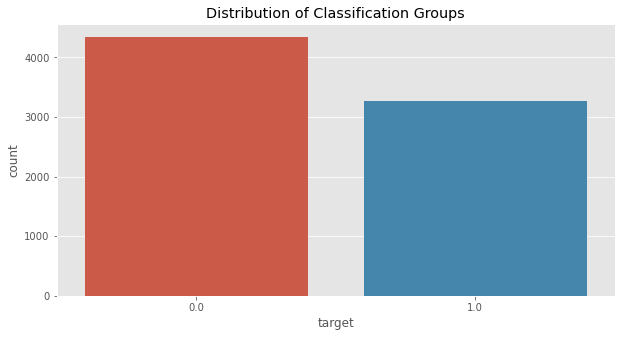

In [6]:
#set figure size
fig, ax = plt.subplots(figsize = (10, 5))

#create graphs
graph1 = sns.countplot(x = 'target', data = total)

#give title and plot
plt.title('Distribution of Classification Groups')
plt.show(graph1)

#### Word Count distribution in the Training dataset :

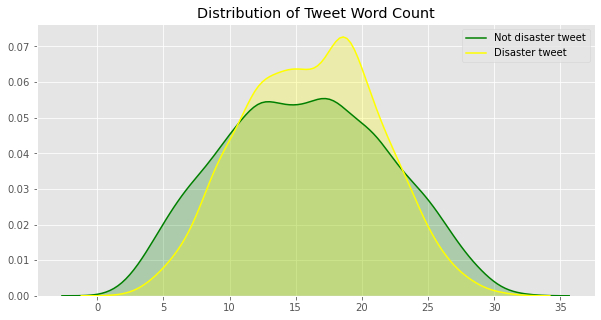

In [7]:
#create column for the number of words in tweet
total['word count'] = total['text'].apply(lambda x: len(x.split()))

#split so we can use updated train set with new feature
train = total[:len(train)]

#define subplot to see graphs side by side
fig, ax = plt.subplots(figsize = (10, 5))

#create graphs
sns.kdeplot(train['word count'][train['target'] == 0], shade = True, label = 'Not disaster tweet', color = "green")
sns.kdeplot(train['word count'][train['target'] == 1], shade = True, label = 'Disaster tweet', color = "yellow")

#set title and plot
plt.title('Distribution of Tweet Word Count')
plt.show()

#### Distribution of Tweet Character Count

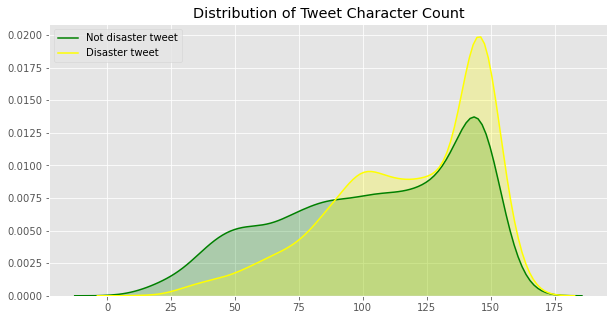

In [8]:
#create column for the number of characters in a tweet
total['character count'] = total['text'].apply(lambda x: len(x))

#split so we can use updated train set with new feature
train = total[:len(train)]

#define subplot to see graphs side by side
fig, ax = plt.subplots(figsize = (10, 5))

#create graphs
sns.kdeplot(train['character count'][train['target'] == 0], shade = True, label = 'Not disaster tweet',  color = "green")
sns.kdeplot(train['character count'][train['target'] == 1], shade = True, label = 'Disaster tweet', color = "yellow")

#set title and plot
plt.title('Distribution of Tweet Character Count')
plt.show()


#### Distribution of Tweet Average Word Length

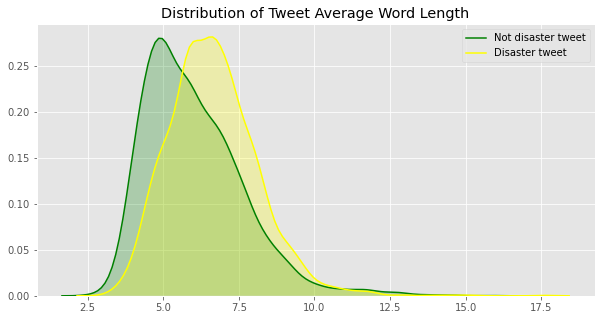

In [9]:
#define function to find average word length 
def average_word_length(x):
    x = x.split()
    return np.mean([len(i) for i in x])

#broadcast to text column
total['average word length'] = total['text'].apply(average_word_length)

#split so we can use updated train set with new feature
train = total[:len(train)]

#define subplot to see graphs side by side
fig, ax = plt.subplots(figsize = (10, 5))

#create graphs
sns.kdeplot(train['average word length'][train['target'] == 0], shade = True, label = 'Not disaster tweet', color = "green")
sns.kdeplot(train['average word length'][train['target'] == 1], shade = True, label = 'Disaster tweet', color = "yellow")

#set title
plt.title('Distribution of Tweet Average Word Length')

#splot graphs
plt.show()

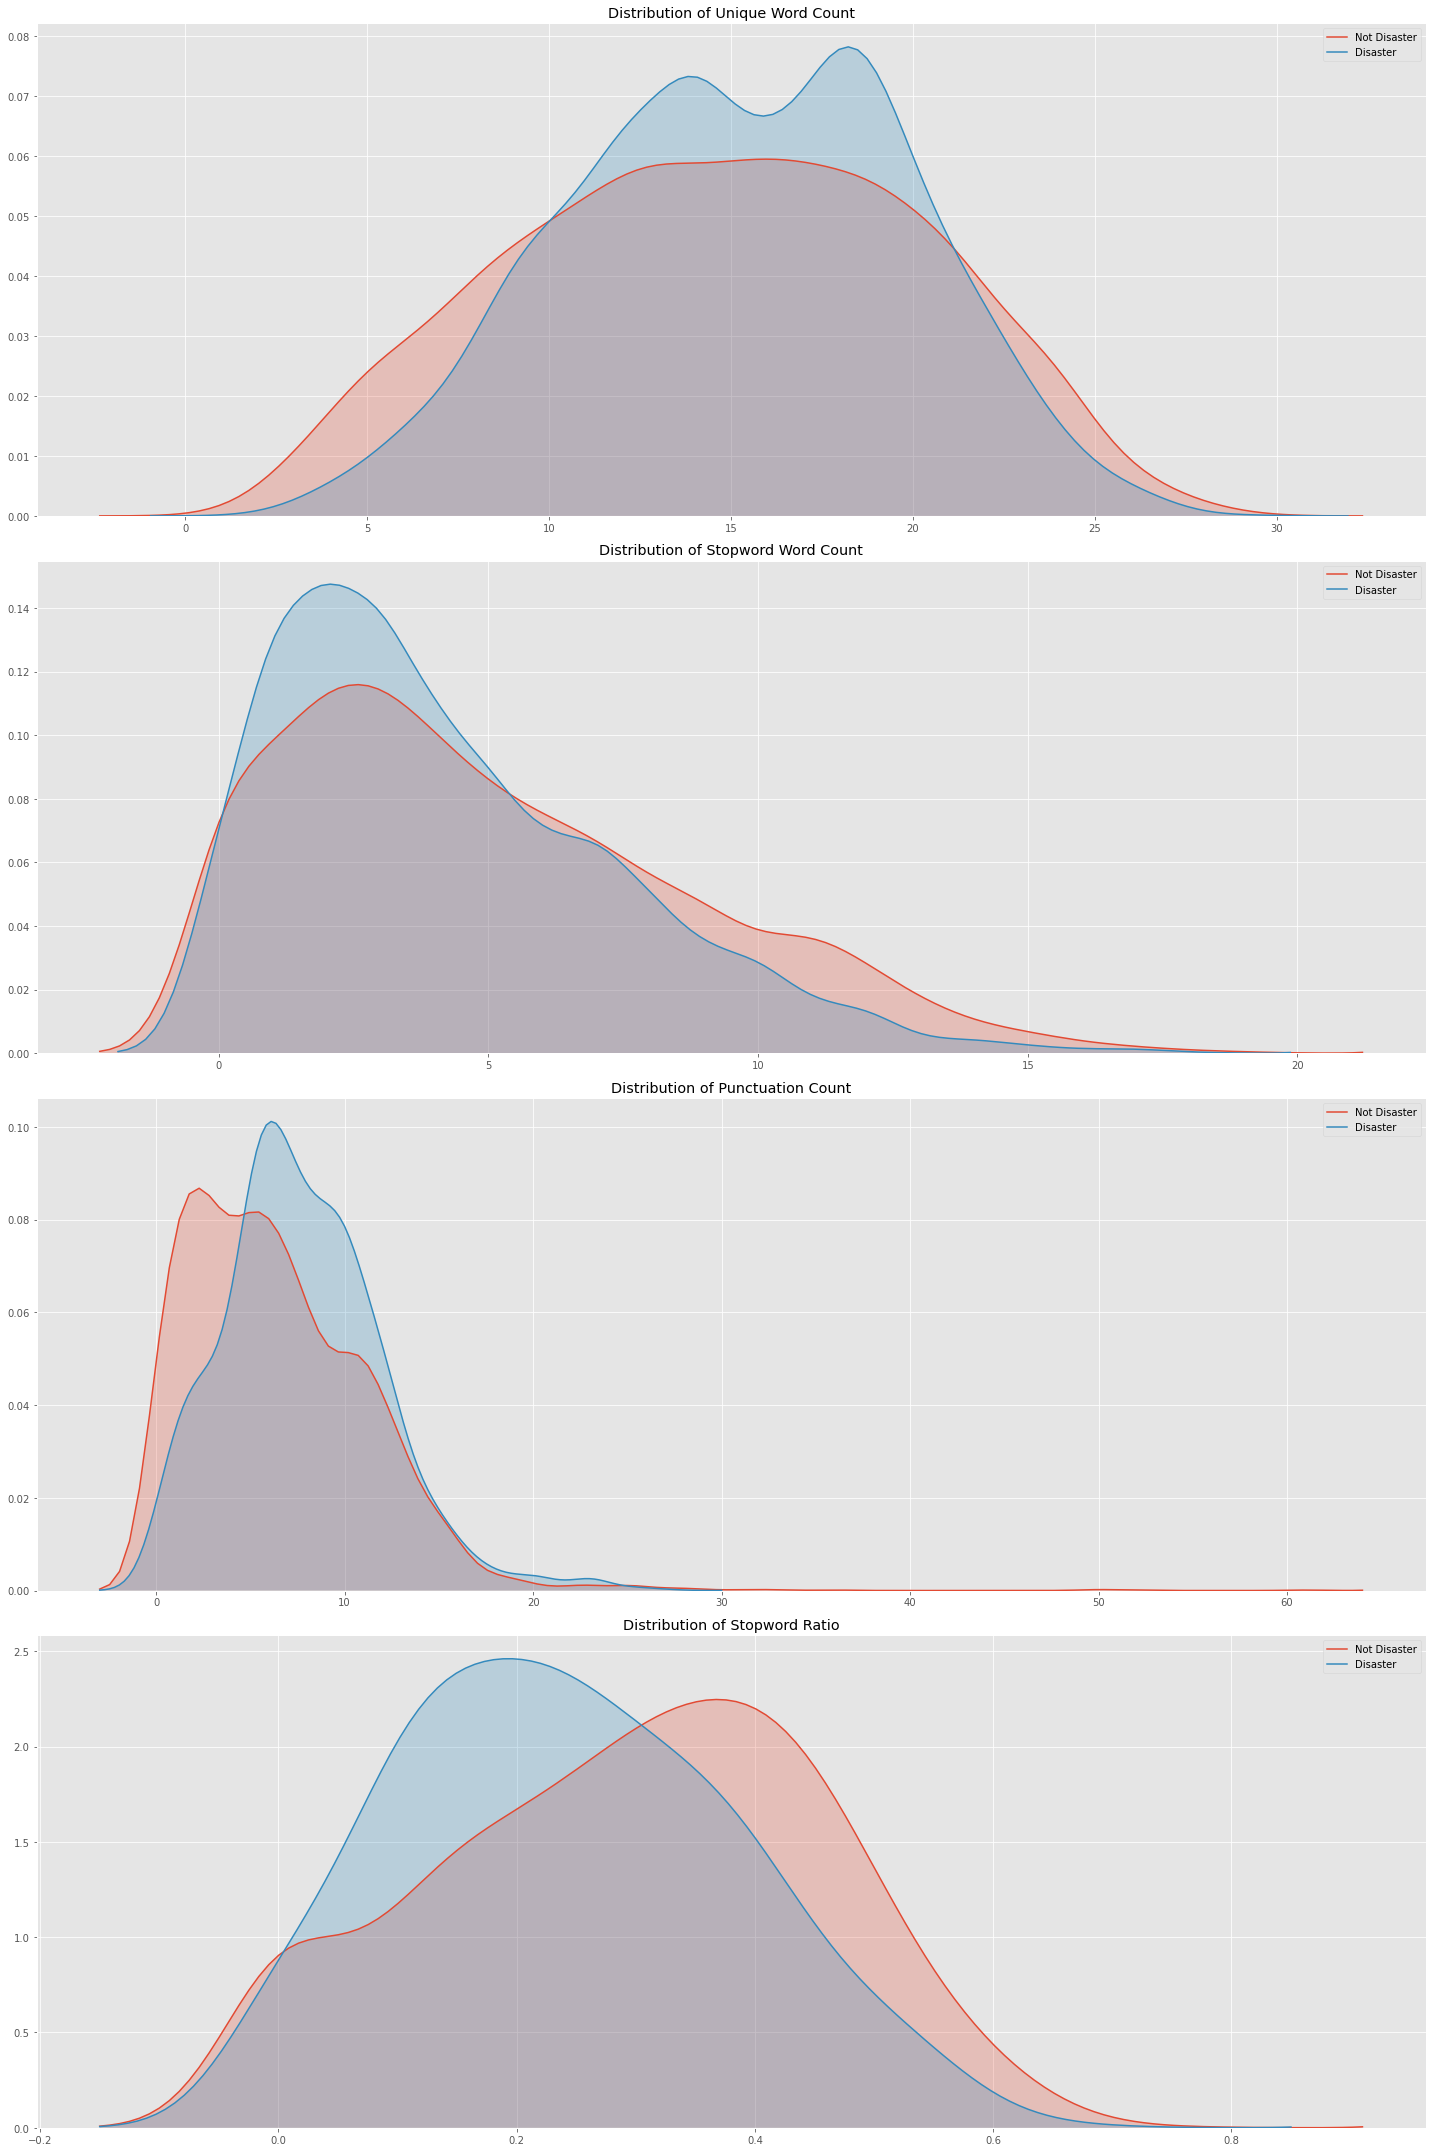

In [10]:
#add unique word count
total['unique word count'] = total['text'].apply(lambda x: len(set(x.split())))

#add stopword count
total['stopword count'] = total['text'].apply(lambda x: len([i for i in x.lower().split() if i in wordcloud.STOPWORDS]))

#add url count
#total['url count'] = total['text'].apply(lambda x: len([i for i in x.lower().split() if 'http' in i or 'https' in i]))

#add mention count
#total['mention count'] = total['text'].apply(lambda x: len([i for i in str(x) if i == '@']))

#add hashtag count
#total['hashtag count'] = total['text'].apply(lambda x: len([i for i in str(x) if i == '#']))

#add stopword ratio
total['stopword ratio'] = total['stopword count'] / total['word count']

#add punctuation count
total['punctuation count'] = total['text'].apply(lambda x: len([i for i in str(x) if i in string.punctuation]))

#split so we can use updated train set
train = total[:len(train)]

disaster = train['target'] == 1

#produce graphs to visualize newly added features
fig, axes = plt.subplots(4, figsize=(20, 30))

graph1 = sns.kdeplot(train.loc[~disaster]['unique word count'], shade = True, label = 'Not Disaster', ax=axes[0])
graph1 = sns.kdeplot(train.loc[disaster]['unique word count'], shade = True, label = 'Disaster', ax=axes[0])
graph1.set_title('Distribution of Unique Word Count')

graph2 = sns.kdeplot(train.loc[~disaster]['stopword count'], shade = True, label = 'Not Disaster', ax=axes[1])
graph2 = sns.kdeplot(train.loc[disaster]['stopword count'], shade = True, label = 'Disaster', ax=axes[1])
graph2.set_title('Distribution of Stopword Word Count')

graph3 = sns.kdeplot(train.loc[~disaster]['punctuation count'], shade = True, label = 'Not Disaster', ax=axes[2], bw = 1)
graph3 = sns.kdeplot(train.loc[disaster]['punctuation count'], shade = True, label = 'Disaster', ax=axes[2], bw = 1)
graph3.set_title('Distribution of Punctuation Count')

graph4 = sns.kdeplot(train.loc[~disaster]['stopword ratio'], shade = True, label = 'Not Disaster', ax=axes[3], bw = .05)
graph4 = sns.kdeplot(train.loc[disaster]['stopword ratio'], shade = True, label = 'Disaster', ax=axes[3], bw = .05)
graph4.set_title('Distribution of Stopword Ratio')

fig.tight_layout()
plt.show()

#### Average word length in each tweet

Text(0.5, 0.98, 'Average word length in each tweet')

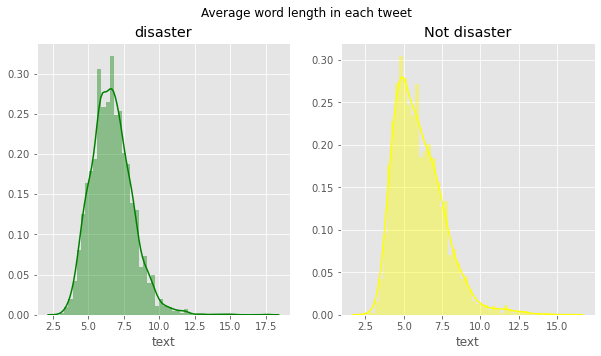

In [11]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='green')
ax1.set_title('disaster')
word=train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='yellow')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

#### Text Processing :

In [12]:
#remove punctuation
def remove_punctuation(x):
    return x.translate(str.maketrans('', '', string.punctuation))

#remove stopwords
def remove_stopwords(x):
    return ' '.join([i for i in x.split() if i not in wordcloud.STOPWORDS])

#remove words less than 4 
def remove_less_than(x):
    return ' '.join([i for i in x.split() if len(i) > 3])

#remove words with non-alphabet characters
def remove_non_alphabet(x):
    return ' '.join([i for i in x.split() if i.isalpha()])

def strip_all_entities(x):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())

def remove_hashtag(x):
    return " ".join(word.strip() for word in re.split('#|_', x))

### Spell Check

In [13]:
#install autocorrect
#!pip install autocorrect
from autocorrect import Speller 

#create function to spell check strings
def spell_check(x):
    spell = Speller(lang='en')
    return " ".join([spell(i) for i in x.split()])

#showcase spellcheck 
mispelled = 'Pleaze spelcheck this sentince'
spell_check(mispelled)

'Please spelcheck this sentence'

#### Applying the Text Pre-Processing to the dataset :

In [14]:
#apply all of above functions
total['text'] = total['text'].apply(lambda x: x.lower())
total['text'] = total['text'].apply(lambda x: re.sub(r'https?://\S+|www\.\S+', '', x, flags = re.MULTILINE))
total['text'] = total['text'].apply(lambda x: re.sub(r'http?://\S+|www\.\S+', '', x, flags = re.MULTILINE))
total['text'] = total['text'].apply(remove_punctuation)
total['text'] = total['text'].apply(remove_stopwords)
    #total['text'] = total['text'].apply(remove_less_than)
total['text'] = total['text'].apply(remove_non_alphabet)
total['text'] = total['text'].apply(remove_hashtag)
    #total['text'] = total['text'].apply(spell_check)
    
    
 

#### We expand all the contractions in our vocabulary to ensure that we do not lose meaning when we tokenize everything

In [15]:
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

contractions_re = re.compile('(%s)' % '|'.join(contractions.keys()))
def expand_contractions(s, contractions = contractions):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, s)



#### Validating the expand_contractions function : 

In [16]:
expand_contractions("can't stop won't stop")

'cannot stop will not stop'

In [17]:
total['text'] = total['text'].apply(expand_contractions)

#### Expanding Abbreviations/acronyms/hashtag/slang/typo corrections
Below are some of the expanded hasgtags/acronyms : 

In [18]:
def clean(tweet):

    #correct some acronyms while we are at it
    tweet = re.sub(r"tnwx", "Tennessee Weather", tweet)
    tweet = re.sub(r"azwx", "Arizona Weather", tweet)  
    tweet = re.sub(r"alwx", "Alabama Weather", tweet)
    tweet = re.sub(r"wordpressdotcom", "wordpress", tweet)      
    tweet = re.sub(r"gawx", "Georgia Weather", tweet)  
    tweet = re.sub(r"scwx", "South Carolina Weather", tweet)  
    tweet = re.sub(r"cawx", "California Weather", tweet)
    tweet = re.sub(r"usNWSgov", "United States National Weather Service", tweet) 
    tweet = re.sub(r"MH370", "Malaysia Airlines Flight 370", tweet)
    tweet = re.sub(r"okwx", "Oklahoma City Weather", tweet)
    tweet = re.sub(r"arwx", "Arkansas Weather", tweet)  
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)  
    tweet = re.sub(r"amirite", "am I right", tweet)
    
    #and some typos/abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)
    
    #hashtags and usernames
    tweet = re.sub(r"IranDeal", "Iran Deal", tweet)
    tweet = re.sub(r"ArianaGrande", "Ariana Grande", tweet)
    tweet = re.sub(r"camilacabello97", "camila cabello", tweet) 
    tweet = re.sub(r"RondaRousey", "Ronda Rousey", tweet)     
    tweet = re.sub(r"MTVHottest", "MTV Hottest", tweet)
    tweet = re.sub(r"TrapMusic", "Trap Music", tweet)
    tweet = re.sub(r"ProphetMuhammad", "Prophet Muhammad", tweet)
    tweet = re.sub(r"PantherAttack", "Panther Attack", tweet)
    tweet = re.sub(r"StrategicPatience", "Strategic Patience", tweet)
    tweet = re.sub(r"socialnews", "social news", tweet)
    tweet = re.sub(r"IDPs:", "Internally Displaced People :", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ClaytonBryant", "Clayton Bryant", tweet)
    tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet)
    tweet = re.sub(r"justinbieber", "justin bieber", tweet)  
    tweet = re.sub(r"Time2015", "Time 2015", tweet)
    tweet = re.sub(r"djicemoon", "dj icemoon", tweet)
    tweet = re.sub(r"LivingSafely", "Living Safely", tweet)
    tweet = re.sub(r"FIFA16", "Fifa 2016", tweet)
    tweet = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", tweet)
    tweet = re.sub(r"bbcnews", "bbc news", tweet)
    tweet = re.sub(r"UndergroundRailraod", "Underground Railraod", tweet)
    tweet = re.sub(r"c4news", "c4 news", tweet)
    tweet = re.sub(r"MUDSLIDE", "mudslide", tweet)
    tweet = re.sub(r"NoSurrender", "No Surrender", tweet)
    tweet = re.sub(r"NotExplained", "Not Explained", tweet)
    tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet)
    tweet = re.sub(r"LondonFire", "London Fire", tweet)
    tweet = re.sub(r"KOTAWeather", "KOTA Weather", tweet)
    tweet = re.sub(r"LuchaUnderground", "Lucha Underground", tweet)
    tweet = re.sub(r"KOIN6News", "KOIN 6 News", tweet)
    tweet = re.sub(r"LiveOnK2", "Live On K2", tweet)
    tweet = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", tweet)
    tweet = re.sub(r"nikeplus", "nike plus", tweet)
    tweet = re.sub(r"david_cameron", "David Cameron", tweet)
    tweet = re.sub(r"peterjukes", "Peter Jukes", tweet)
    tweet = re.sub(r"MikeParrActor", "Michael Parr", tweet)
    tweet = re.sub(r"4PlayThursdays", "Foreplay Thursdays", tweet)
    tweet = re.sub(r"TGF2015", "Tontitown Grape Festival", tweet)
    tweet = re.sub(r"realmandyrain", "Mandy Rain", tweet)
    tweet = re.sub(r"GraysonDolan", "Grayson Dolan", tweet)
    tweet = re.sub(r"ApolloBrown", "Apollo Brown", tweet)
    tweet = re.sub(r"saddlebrooke", "Saddlebrooke", tweet)
    tweet = re.sub(r"TontitownGrape", "Tontitown Grape", tweet)
    tweet = re.sub(r"AbbsWinston", "Abbs Winston", tweet)
    tweet = re.sub(r"ShaunKing", "Shaun King", tweet)
    tweet = re.sub(r"MeekMill", "Meek Mill", tweet)
    tweet = re.sub(r"TornadoGiveaway", "Tornado Giveaway", tweet)
    tweet = re.sub(r"GRupdates", "GR updates", tweet)
    tweet = re.sub(r"SouthDowns", "South Downs", tweet)
    tweet = re.sub(r"braininjury", "brain injury", tweet)
    tweet = re.sub(r"auspol", "Australian politics", tweet)
    tweet = re.sub(r"PlannedParenthood", "Planned Parenthood", tweet)
    tweet = re.sub(r"calgaryweather", "Calgary Weather", tweet)
    tweet = re.sub(r"weallheartonedirection", "we all heart one direction", tweet)
    tweet = re.sub(r"edsheeran", "Ed Sheeran", tweet)
    tweet = re.sub(r"TrueHeroes", "True Heroes", tweet)
    tweet = re.sub(r"ComplexMag", "Complex Magazine", tweet)
    tweet = re.sub(r"TheAdvocateMag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"CityofCalgary", "City of Calgary", tweet)
    tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet)
    tweet = re.sub(r"SummerFate", "Summer Fate", tweet)
    tweet = re.sub(r"RAmag", "Royal Academy Magazine", tweet)
    tweet = re.sub(r"offers2go", "offers to go", tweet)
    tweet = re.sub(r"ModiMinistry", "Modi Ministry", tweet)
    tweet = re.sub(r"TAXIWAYS", "taxi ways", tweet)
    tweet = re.sub(r"Calum5SOS", "Calum Hood", tweet)
    tweet = re.sub(r"JamesMelville", "James Melville", tweet)
    tweet = re.sub(r"JamaicaObserver", "Jamaica Observer", tweet)
    tweet = re.sub(r"TweetLikeItsSeptember11th2001", "Tweet like it is september 11th 2001", tweet)
    tweet = re.sub(r"cbplawyers", "cbp lawyers", tweet)
    tweet = re.sub(r"fewmoretweets", "few more tweets", tweet)
    tweet = re.sub(r"BlackLivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet)
    tweet = re.sub(r"humanconsumption", "human consumption", tweet)
    tweet = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", tweet)
    tweet = re.sub(r"Meat-Loving", "Meat Loving", tweet)
    tweet = re.sub(r"facialabuse", "facial abuse", tweet)
    tweet = re.sub(r"LakeCounty", "Lake County", tweet)
    tweet = re.sub(r"BeingAuthor", "Being Author", tweet)
    tweet = re.sub(r"withheavenly", "with heavenly", tweet)
    tweet = re.sub(r"thankU", "thank you", tweet)
    tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet)
    tweet = re.sub(r"OffensiveContent", "Offensive Content", tweet)
    tweet = re.sub(r"WorstSummerJob", "Worst Summer Job", tweet)
    tweet = re.sub(r"HarryBeCareful", "Harry Be Careful", tweet)
    tweet = re.sub(r"NASASolarSystem", "NASA Solar System", tweet)
    tweet = re.sub(r"animalrescue", "animal rescue", tweet)
    tweet = re.sub(r"KurtSchlichter", "Kurt Schlichter", tweet)
    tweet = re.sub(r"Throwingknifes", "Throwing knives", tweet)
    tweet = re.sub(r"GodsLove", "God's Love", tweet)
    tweet = re.sub(r"bookboost", "book boost", tweet)
    tweet = re.sub(r"ibooklove", "I book love", tweet)
    tweet = re.sub(r"NestleIndia", "Nestle India", tweet)
    tweet = re.sub(r"realDonaldTrump", "Donald Trump", tweet)
    tweet = re.sub(r"DavidVonderhaar", "David Vonderhaar", tweet)
    tweet = re.sub(r"CecilTheLion", "Cecil The Lion", tweet)
    tweet = re.sub(r"weathernetwork", "weather network", tweet)
    tweet = re.sub(r"GOPDebate", "GOP Debate", tweet)
    tweet = re.sub(r"RickPerry", "Rick Perry", tweet)
    tweet = re.sub(r"frontpage", "front page", tweet)
    tweet = re.sub(r"NewsInTweets", "News In Tweets", tweet)
    tweet = re.sub(r"ViralSpell", "Viral Spell", tweet)
    tweet = re.sub(r"til_now", "until now", tweet)
    tweet = re.sub(r"volcanoinRussia", "volcano in Russia", tweet)
    tweet = re.sub(r"ZippedNews", "Zipped News", tweet)
    tweet = re.sub(r"MicheleBachman", "Michele Bachman", tweet)
    tweet = re.sub(r"53inch", "53 inch", tweet)
    tweet = re.sub(r"KerrickTrial", "Kerrick Trial", tweet)
    tweet = re.sub(r"abstorm", "Alberta Storm", tweet)
    tweet = re.sub(r"Beyhive", "Beyonce hive", tweet)
    tweet = re.sub(r"RockyFire", "Rocky Fire", tweet)
    tweet = re.sub(r"Listen/Buy", "Listen / Buy", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ENGvAUS", "England vs Australia", tweet)
    tweet = re.sub(r"ScottWalker", "Scott Walker", tweet)

    return tweet

total['text'] = total['text'].apply(clean)

#### DATA PARTITION

In [19]:
tweets = [tweet for tweet in total['text']]

#split data to update changes
train = total[:len(train)]
test = total[len(train):]

#### N-GRAM ANALYSIS

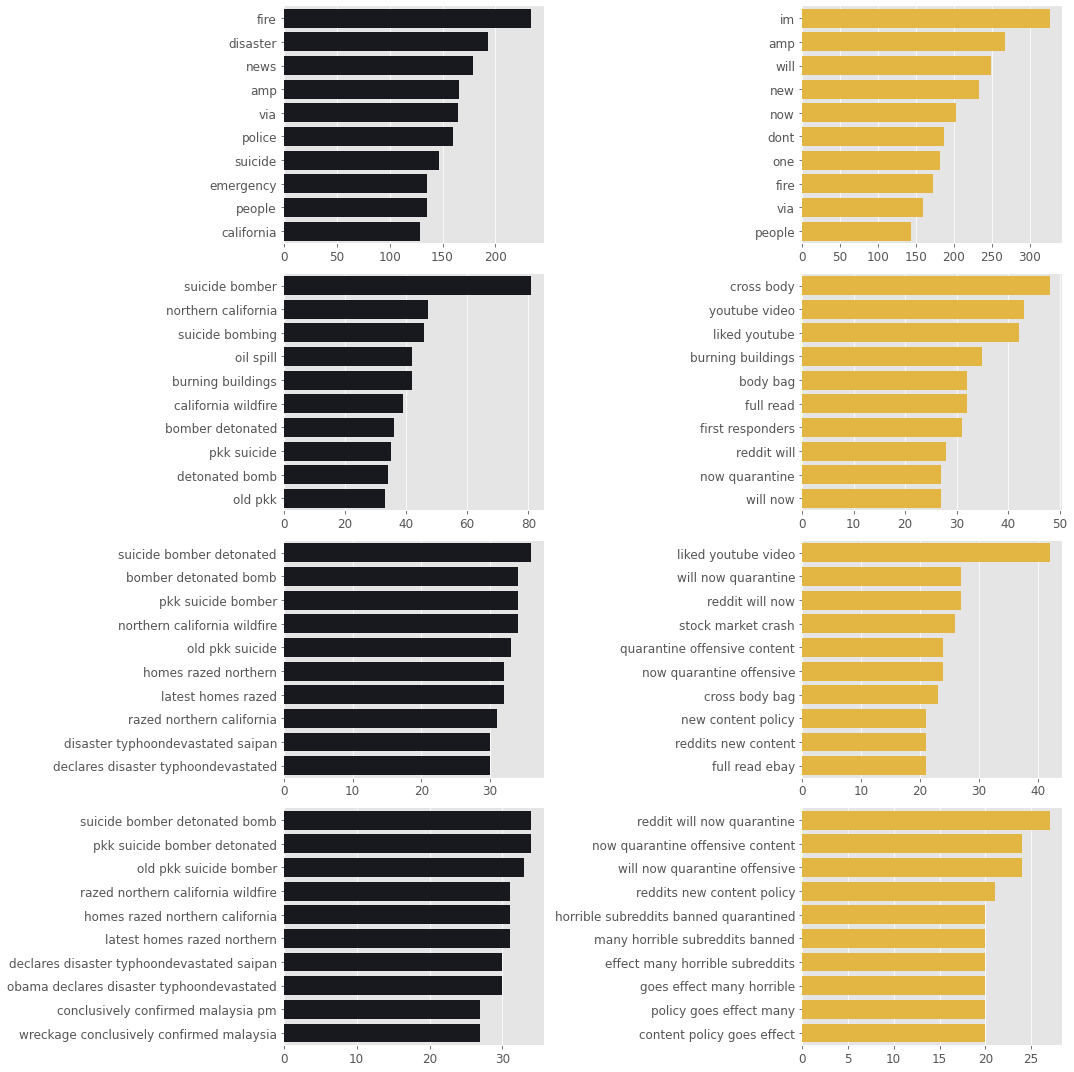

In [20]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in wordcloud.STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

###################################################
#### Unigrams
###################################################

disaster_unigrams = defaultdict(int)
for word in total[train['target'] == 1]['text']:
    for word in generate_ngrams(word, n_gram = 1):
        disaster_unigrams[word] += 1
disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])

nondisaster_unigrams = defaultdict(int)
for word in total[train['target'] == 0]['text']:
    for word in generate_ngrams(word, n_gram = 1):
        nondisaster_unigrams[word] += 1
nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

###################################################
#### Bigrams
###################################################

disaster_bigrams = defaultdict(int)
for word in total[train['target'] == 1]['text']:
    for word in generate_ngrams(word, n_gram = 2):
        disaster_bigrams[word] += 1
disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])

nondisaster_bigrams = defaultdict(int)
for word in total[train['target'] == 0]['text']:
    for word in generate_ngrams(word, n_gram = 2):
        nondisaster_bigrams[word] += 1
nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

###################################################
#### Trigrams
###################################################

disaster_trigrams = defaultdict(int)
for word in total[train['target'] == 1]['text']:
    for word in generate_ngrams(word, n_gram = 3):
        disaster_trigrams[word] += 1
disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])

nondisaster_trigrams = defaultdict(int)
for word in total[train['target'] == 0]['text']:
    for word in generate_ngrams(word, n_gram = 3):
        nondisaster_trigrams[word] += 1
nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

###################################################
#### 4-grams
###################################################

disaster_4grams = defaultdict(int)
for word in total[train['target'] == 1]['text']:
    for word in generate_ngrams(word, n_gram = 4):
        disaster_4grams[word] += 1
disaster_4grams = pd.DataFrame(sorted(disaster_4grams.items(), key=lambda x: x[1])[::-1])

nondisaster_4grams = defaultdict(int)
for word in total[train['target'] == 0]['text']:
    for word in generate_ngrams(word, n_gram = 4):
        nondisaster_4grams[word] += 1
nondisaster_4grams = pd.DataFrame(sorted(nondisaster_4grams.items(), key=lambda x: x[1])[::-1])
N = 10

fig, ax = plt.subplots(4, 2, figsize = (15, 15))
plt.tight_layout()

sns.barplot(y = disaster_unigrams[0].values[:N], x = disaster_unigrams[1].values[:N], ax = ax[0, 0], color='#171820')
sns.barplot(y = nondisaster_unigrams[0].values[:N], x = nondisaster_unigrams[1].values[:N], ax = ax[0, 1], color = '#fdc029')

sns.barplot(y = disaster_bigrams[0].values[:N], x = disaster_bigrams[1].values[:N], ax = ax[1, 0], color='#171820')
sns.barplot(y = nondisaster_bigrams[0].values[:N], x = nondisaster_bigrams[1].values[:N], ax = ax[1, 1], color = '#fdc029')

sns.barplot(y = disaster_trigrams[0].values[:N], x = disaster_trigrams[1].values[:N], ax = ax[2, 0], color='#171820')
sns.barplot(y = nondisaster_trigrams[0].values[:N], x = nondisaster_trigrams[1].values[:N], ax = ax[2, 1], color = '#fdc029')

sns.barplot(y = disaster_4grams[0].values[:N], x = disaster_4grams[1].values[:N], ax = ax[3, 0], color='#171820')
sns.barplot(y = nondisaster_4grams[0].values[:N], x = nondisaster_4grams[1].values[:N], ax = ax[3, 1], color = '#fdc029')

for i in range(0, 4):
    for j in range(0, 2):
        ax[i, j].spines['right'].set_visible(False)
        ax[i, j].spines['left'].set_visible(False)
        ax[i, j].spines['top'].set_visible(False)
        ax[i, j].set_xlabel('')
        ax[i, j].set_ylabel('')
        ax[i, j].tick_params(axis='x', labelsize=12)
        ax[i, j].tick_params(axis='y', labelsize=12)
    

plt.tight_layout()
plt.show()

In [21]:
from keras.preprocessing.text import Tokenizer

#find way to tokenize punctuation
to_exclude = '*+-/()#?!%\n[\\]{|}^_`~\t'
to_tokenize = '!"#$&?:;<=>@'
tokenizer = Tokenizer(filters = to_exclude)
text = 'Why are you so f%#@ing angry all the time?!'
text = re.sub(r'(['+to_tokenize+'])', r' \1 ', text)
tokenizer.fit_on_texts([text])

#view new text
print(tokenizer.word_index)

{'why': 1, 'are': 2, 'you': 3, 'so': 4, 'f': 5, '@': 6, 'ing': 7, 'angry': 8, 'all': 9, 'the': 10, 'time': 11}


#### Tokenization

In [22]:
from keras.preprocessing.sequence import pad_sequences
from keras import Input

#define tokenizer options
tokenizer = Tokenizer()     
tokenizer.fit_on_texts(tweets)
sequences = tokenizer.texts_to_sequences(tweets)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences)
labels = train['target']
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

nlp_train = data[:len(train)]
labels = labels
nlp_test = data[len(train):]

MAX_SEQUENCE_LENGTH = data.shape[1]


Found 20200 unique tokens.
Shape of data tensor: (10876, 25)
Shape of label tensor: (7613,)


### Model 3: GLOVE MODEL WITH LSTM
We have used Wikipedia GloVe embeddings

In [23]:
embeddings_index = {}
with open('glove.6B.200d.txt','r') as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
f.close()

print('Found %s word vectors in the GloVe library' % len(embeddings_index))

400000it [00:19, 20060.66it/s]

Found 400000 word vectors in the GloVe library


In [24]:
EMBEDDING_DIM = 200   
#initialize embedding matrix with zeros
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

#add glove word encodings to our library
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        
        #words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
print("Our embedded matrix is of dimension", embedding_matrix.shape)

100%|██████████| 20200/20200 [00:00<00:00, 116708.90it/s]

Our embedded matrix is of dimension (20201, 200)


In [25]:
#import neural network basic
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Dropout, Concatenate, LeakyReLU, GRU
from keras import Input, Model, regularizers
from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import EarlyStopping

embedding = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights = [embedding_matrix],
                     input_length = MAX_SEQUENCE_LENGTH, trainable = False)  



In [26]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

def scale(df, scaler):
    return scaler.fit_transform(df.iloc[:, 2:])

#and scal
meta_train = scale(train, StandardScaler())
meta_test = scale(test, StandardScaler())

#### LSTM
We will now design a Long Short-Term Memory (LSTM) recurrent neural network to classify our tweets to see how it performs on the leaderboard



In [27]:
#function to create lstm model
def create_lstm(spatial_dropout, dropout, recurrent_dropout, learning_rate, bidirectional = False):
    #define activation
    activation = LeakyReLU(alpha = 0.01)
    
    #define inputs
    nlp_input = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'nlp_input')
    meta_input_train = Input(shape = (7, ), name = 'meta_train')
    emb = embedding(nlp_input)
    emb = SpatialDropout1D(dropout)(emb)

    #add LSTM layer
    if bidirectional:
        nlp_out = (Bidirectional(LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal')))(emb)
    else:
        nlp_out = (LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal'))(emb)        
     
    #add meta data    
    x = Concatenate()([nlp_out, meta_input_train])
    
    #add output layer
    x = Dropout(dropout)(x)
    preds = Dense(1, activation='sigmoid', kernel_regularizer = regularizers.l2(1e-4))(x)
    
    #compile model
    model = Model(inputs=[nlp_input , meta_input_train], outputs = preds)
    optimizer = Adam(learning_rate = learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model



#define conveient training function to visualize learning curves
def plot_learning_curves(history): 
    fig, ax = plt.subplots(1, 2, figsize = (20, 10))

    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])

    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])

    ax[0].legend(['train', 'validation'], loc = 'upper left')
    ax[1].legend(['train', 'validation'], loc = 'upper left')

    fig.suptitle("Model Accuracy", fontsize=14)

    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')

    return plt.show()

#### Model compilation :

In [28]:
#create our first model
lstm = create_lstm(spatial_dropout = .2, dropout = .2, recurrent_dropout = .2,
                     learning_rate = 3e-4, bidirectional = True)
lstm.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
nlp_input (InputLayer)          [(None, 25)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 25, 200)      4040200     nlp_input[0][0]                  
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 25, 200)      0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 200)          240800      spatial_dropout1d[0][0]          
_______________________________________________________________________________________

In [29]:
#fit model
history1 = lstm.fit([nlp_train, meta_train], labels, validation_split = .2,
                       epochs = 10, batch_size = 21, verbose = 1)

Epoch 1/10
290/290 [==============================] - 14s 49ms/step - loss: 0.5096 - accuracy: 0.7514 - val_loss: 0.4229 - val_accuracy: 0.8070
Epoch 2/10
290/290 [==============================] - 13s 45ms/step - loss: 0.4557 - accuracy: 0.7947 - val_loss: 0.4089 - val_accuracy: 0.8194
Epoch 3/10
290/290 [==============================] - 18s 62ms/step - loss: 0.4405 - accuracy: 0.7979 - val_loss: 0.4138 - val_accuracy: 0.8168
Epoch 4/10
290/290 [==============================] - 15s 53ms/step - loss: 0.4320 - accuracy: 0.8077 - val_loss: 0.4057 - val_accuracy: 0.8201
Epoch 5/10
290/290 [==============================] - 16s 54ms/step - loss: 0.4176 - accuracy: 0.8174 - val_loss: 0.4037 - val_accuracy: 0.8175
Epoch 6/10
290/290 [==============================] - 15s 50ms/step - loss: 0.4126 - accuracy: 0.8227 - val_loss: 0.4209 - val_accuracy: 0.8102
Epoch 7/10
290/290 [==============================] - 14s 47ms/step - loss: 0.4069 - accuracy: 0.8186 - val_loss: 0.4073 - val_accuracy:

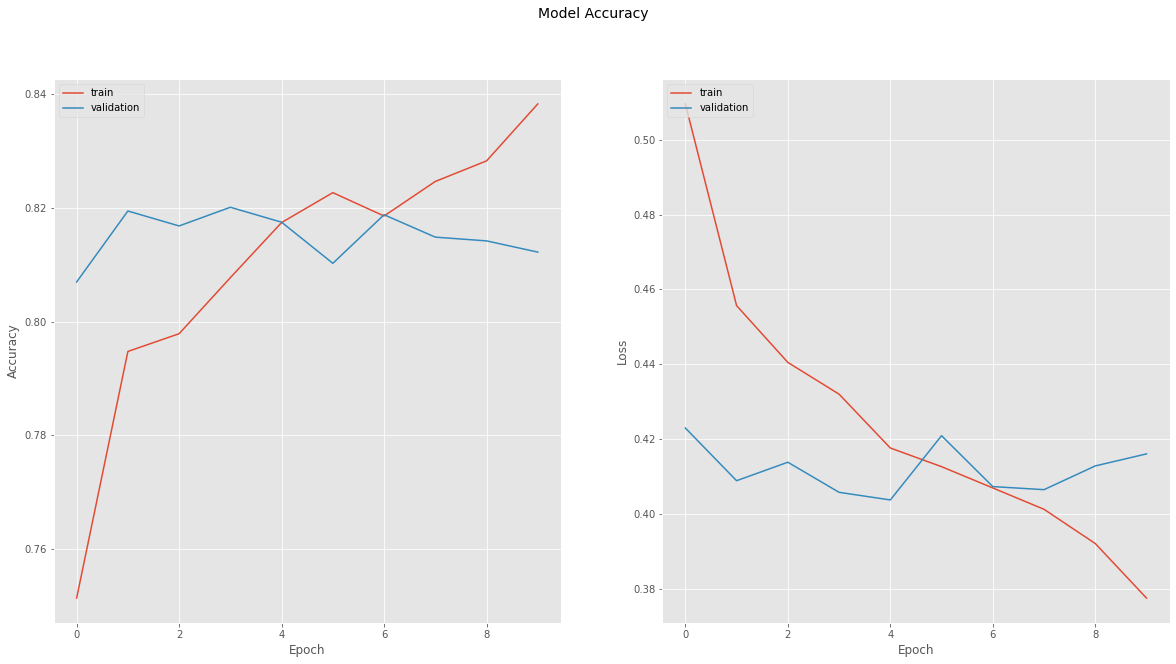

In [30]:
plot_learning_curves(history1)

In [31]:
#create submission for lstm model with Glove embedding
submission_lstm = pd.DataFrame()
submission_lstm['id'] = test_id
submission_lstm['prob'] = lstm.predict([nlp_test, meta_test])
submission_lstm['target'] = submission_lstm['prob'].apply(lambda x: 0 if x < .5 else 1)
submission_lstm.head(20)

,id,prob,target
0,0,0.273936,0
1,2,0.722486,1
2,3,0.827503,1
3,9,0.438718,0
4,11,0.981616,1
5,12,0.260832,0
6,21,0.098968,0
7,22,0.041837,0
8,27,0.029715,0
9,29,0.042491,0


####  Model Predictions 

In [39]:
for i,j in zip(train.text.values, submission_lstm['target']):
    print("Tweet to predict : ",i)
    print("The Category found is :", "[1] Disaster tweet" if j==1 else "[0] Not a Disaster tweet")
    

Tweet to predict :  deeds reason earthquake may allah forgive us
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  forest fire near la ronge sask canada
The Category found is : [1] Disaster tweet
Tweet to predict :  residents asked shelter place notified officers evacuation shelter place orders expected
The Category found is : [1] Disaster tweet
Tweet to predict :  people receive wildfires evacuation orders california
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  got sent photo ruby alaska smoke wildfires pours school
The Category found is : [1] Disaster tweet
Tweet to predict :  rockyfire update california hwy closed directions due lake county fire cafire wildfires
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  flood disaster heavy rain causes flash flooding streets manitou colorado springs areas
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  im top hill see fire woods
The Category found is : [0] Not

Tweet to predict :  spotlight take paradise arsonist mc wniagospel arsonistmusic arsonist
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  makes arsonist
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  town salem melted ice cube bc im arsonist d arsonist
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  arsonists blamed blaze plastics recycling business adelaide reports arsonist
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  hotboy shit arsonist
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  zodiac girl feat trey dupree produced sparkz beatz chuck da arsonist arsonist
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  localarsonist lmfao arsonist
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  alleged east bay serial arsonist arrested sanfrancisco arsonist
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  doofus diamorfiend im

Tweet to predict :  artisteoftheweekfact say conversations agree crystalblaz s jiwonle hiphop clubbanger blaze
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  bright amp blazing fireman birthday party weddings blazing
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  real vibez radio blazing best vibez nowplaying listenlive blazing
The Category found is : [1] Disaster tweet
Tweet to predict :  montgomery come blazing hot weatherstay stds yet another rejected city slogan blazing
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  come join us tomorrow august transcendblazing trail diversified world marketing blazing
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  morgan silver dollar s gem bu dmpl cameo rev blazing ms high grade full read blazing
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  morgan silver dollar s gem bu dmpl cameo rev blazing ms high grade full read blazing
The Category

Tweet to predict :  swear secret well uncover old gods slumber think theres gonna another blight blight
The Category found is : [1] Disaster tweet
Tweet to predict :  willhillbet double result live app blight
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  parksboardfacts first zippoline one wants use community never asked blight park moveit blight
The Category found is : [1] Disaster tweet
Tweet to predict :  look policy matters ohio report cle cuyahoga county blight greening vacant lands soon blight
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  anellatulip put taint magisters open gates let blight away blight
The Category found is : [1] Disaster tweet
Tweet to predict :  anellatulip theory makes way much sense says dwarves may actual origin blight blight
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  palestinian refugee tragedy blight humanity amp shame every israeli living blight
The Category found is : [0] Not a Disa

The Category found is : [0] Not a Disaster tweet
Tweet to predict :  traintragedy happened mp due collapse bridge now m afraid take long distance train
The Category found is : [1] Disaster tweet
Tweet to predict :  listening blowers tuffers aussie batting collapse trent bridge reminds love bbctms wonderful stuff engvaus
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  two giant cranes holding bridge collapse nearby homes
The Category found is : [1] Disaster tweet
Tweet to predict :  two giant cranes holding bridge collapse nearby homes
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  computers gadgets two giant cranes holding bridge collapse nearby homes slingnews
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  australias ashes disaster collapse unfolded trent bridge telegraph
The Category found is : [1] Disaster tweet
Tweet to predict :  followlasg urgentthere currently storey building church bstop oworoshoki third mainland 

The Category found is : [0] Not a Disaster tweet
Tweet to predict :  day liquidation emergency chemical object ruor
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  emergency units simulate chemical explosion nu evanston now
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  please stand bees profithungry chemical companies keep ban amp savebees sign petition now
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  laevantine fortunately reworked plumbing emergency chemical shower draw glitter pipe occasion
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  chemicalbabe family emergency cant make unless chance use phone stream
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  emergency harbor city mod chemical fire residential area via youtube
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  emergency responders prepare chemical disaster hazmat training
The Category found is :

The Category found is : [1] Disaster tweet
Tweet to predict :  curfew will start right private class ends tutor must woman preferably someone curfew
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  aptlyengineerd curfew curfew
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  past curfew grove curfew
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  emmychappy oclock mom said everyone go home curfew curfew
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  reddakushgodd said months curfew time smfh curfew
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  ball curfew curfew
The Category found is : [1] Disaster tweet
Tweet to predict :  scotrail seen turn blind eye bloke drinking smoking curfew time cosits worth hassle curfew
The Category found is : [1] Disaster tweet
Tweet to predict :  next may ill freefrom school obligations family best damn curfew curfew
The Category found is : [0] Not a Di

The Category found is : [0] Not a Disaster tweet
Tweet to predict :  charminar demolish falling state anyway take engineers opinion telangana demolish
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  beastin tapas evening good folk funtimes demolished demolished
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  uribe demolished ball demolished
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  bought jar peanut butter getting demolished demolished
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  colts demolished patriots whine nfl integrity cantmakeitup patriotsnation demolished
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  flunkie makes feel better im level still demolished demolished
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  angusmacneilsnp every case yes utterly demolished utterly embarrassed bring indy demolished
The Category found is : [0] Not a Disaster t

Tweet to predict :  killed injured madhya pradesh twin train derailment derailment
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  trains derailment freakiest freak accidents indian express derailment
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  photos green line derailment near cottage grove garfield derailment
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  modiministry railway minister prabhu calls mp derailment natural calamity derailment
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  train derailment patna news casualty far indian express derailment
The Category found is : [1] Disaster tweet
Tweet to predict :  green line derailment concern track looks goes bit cta ctafails derailment
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  sad learn derailment trains mpmy deepest condolences families lost loved ones mishap officeofrg derailment
The Category found is : [0] Not a Dis

Tweet to predict :  tomfromireland bbctalkback didnt succeed two times either bomb didnt detonateampshots missed detonate
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  press play apollobrowns new single mop detonate detonate
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  apollo brown detonate ftåêmop detonate
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  tinyjecht another standuser will detonate killer queen detonate
The Category found is : [1] Disaster tweet
Tweet to predict :  hiphop news indie apollo brown ft mop lta href detonate
The Category found is : [1] Disaster tweet
Tweet to predict :  new music apollobrown featuring mop detonate taken album grandeur coming soon detonate
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  ignition knock detonation sensorsenso standard fits mazda detonation
The Category found is : [1] Disaster tweet
Tweet to predict :  ignition knock detonation sensor connecto

Tweet to predict :  treasures revealed california drought drains lakes drought
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  canada bc drought okanagan region issued level rating okanagan river columbia trib fishing suspended sep drought
The Category found is : [1] Disaster tweet
Tweet to predict :  time away droughtcheck cloud iot helping conserve water drought
The Category found is : [1] Disaster tweet
Tweet to predict :  mlb bluejays salty scared drought said drought
The Category found is : [1] Disaster tweet
Tweet to predict :  tips finding customers ego drought dqsvyusy drought
The Category found is : [1] Disaster tweet
Tweet to predict :  blog rain much needed drought conditions worsen right now charlotte much surrounding area drought
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  weed news marijuana making california drought worse christian science monitor drought
The Category found is : [1] Disaster tweet
Tweet to predict :  droughtm

Tweet to predict :  contruction upgrading ferries earthquake standards vashon mukilteo upgrades will bring vulnera earthquake
The Category found is : [1] Disaster tweet
Tweet to predict :  gpv wind wnw e s earthquake
The Category found is : [1] Disaster tweet
Tweet to predict :  nnw lake henshaw california earthquake
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  earthquake drill atm earthquake
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  real tear shelli s eyes entire episode earthquake
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  usgs m e interlaken california ep sm earthquake
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  sismo m nne geysers california cs earthquake
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  earthquake drill earthquake
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  darchambau thx great encouragement rt new video coming apocalypt

The Category found is : [1] Disaster tweet
Tweet to predict :  good tips family emergency plan
The Category found is : [1] Disaster tweet
Tweet to predict :  cityofcalgary activates emergency plan amid severe thunderstorm warning yyc Alberta Storm
The Category found is : [1] Disaster tweet
Tweet to predict :  city calgary activates municipal emergency plan
The Category found is : [1] Disaster tweet
Tweet to predict :  govt plan lifeline fci waste money ask people store grains fr months fr emergency enough capacity available nw
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  know emergency plan workplace ask supervisor operations manager retail
The Category found is : [0] Not a Disaster tweet
Tweet to predict :  nhs england announces new plan meet emergency care targets
The Category found is : [1] Disaster tweet
Tweet to predict :  city activated municipal emergency plan primarily stay indoors avoid flooded areas call
The Category found is : [0] Not a Disaster tweet